# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 for all logs, 2 for errors only

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from scipy.spatial import ConvexHull

from mpl_toolkits.mplot3d import Axes3D

## Get data

In [2]:
mnist = keras.datasets.mnist

# Autoencoder

### training data

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_train.max())
print(x_test.shape)
print(x_test.max())

(60000, 28, 28, 1)
1.0
(10000, 28, 28, 1)
1.0


### parameters

In [5]:
latent_dim = 2
hidden_dim = 64
batch_size = 128
epochs = 10
learning_rate = 0.004

factor = 0.1
patience = 1
min_lr = 0.00001
verbose = 1

In [6]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor,
                              patience=patience, min_lr=min_lr, verbose=verbose)

In [7]:
# encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(hidden_dim/2, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(hidden_dim, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# reparameterization
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * hidden_dim, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, hidden_dim))(x)
x = layers.Conv2DTranspose(hidden_dim, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(hidden_dim/2, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# vae model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_inputs, decoder_outputs, name='decoder')

vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name='vae')

# loss function
xent_loss = keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
xent_loss = K.sum(xent_loss, axis=[1, 2])  # Sum over spatial dimensions
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# compile
vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='binary_crossentropy')

In [8]:
fitting_output = vae.fit(x_train, x_train, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data=(x_test, x_test), 
                         callbacks=[reduce_lr])

Epoch 1/10
469/469 [==============================] - 43s 88ms/step - loss: 185.9396 - val_loss: 164.8444 - lr: 0.0040
Epoch 2/10
469/469 [==============================] - 44s 94ms/step - loss: 162.1159 - val_loss: 160.8637 - lr: 0.0040
Epoch 3/10
469/469 [==============================] - 44s 94ms/step - loss: 159.4215 - val_loss: 158.9304 - lr: 0.0040
Epoch 4/10
469/469 [==============================] - 45s 96ms/step - loss: 158.0854 - val_loss: 157.1913 - lr: 0.0040
Epoch 5/10
469/469 [==============================] - 43s 92ms/step - loss: 157.2397 - val_loss: 156.3884 - lr: 0.0040
Epoch 6/10
469/469 [==============================] - ETA: 0s - loss: 156.5798
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
469/469 [==============================] - 46s 98ms/step - loss: 156.5798 - val_loss: 156.6550 - lr: 0.0040
Epoch 7/10
469/469 [==============================] - 52s 111ms/step - loss: 154.2853 - val_loss: 154.3840 - lr: 4.0000e-04
Epoch 8/10
469/469

In [9]:
training_history = fitting_output.history

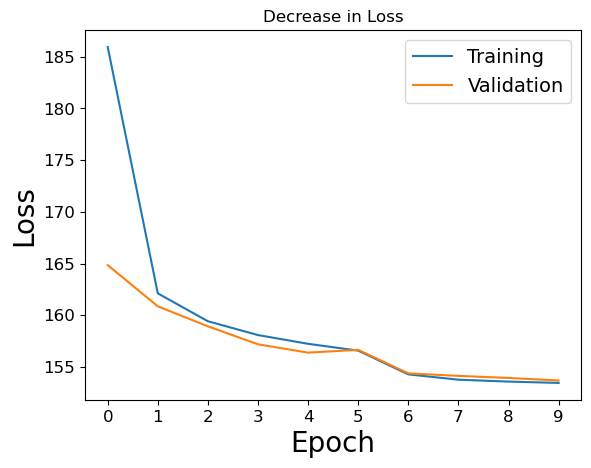

In [10]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

# Plotting the latent space

In [11]:
x_data = []
y_data = []

for number in range(10):
    images = np.load(f'./split_by_number/{number}_images.npy')
    images_reshaped = images.reshape(-1, 28, 28, 1)

    encoded_imgs = encoder.predict(images_reshaped)
    encoded_imgs = np.array(encoded_imgs)

    x_data.append(encoded_imgs[:, 0])
    y_data.append(encoded_imgs[:, 1])


186/186 [==============================] - 0s 2ms/step


## Plot of all images

In [15]:
# encoder = Model(inputs, z_mean)  # Assuming `z_mean` is the output of your encoder
z_means = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [16]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Latent Space Visualization of VAE')
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 800x600 with 0 Axes>

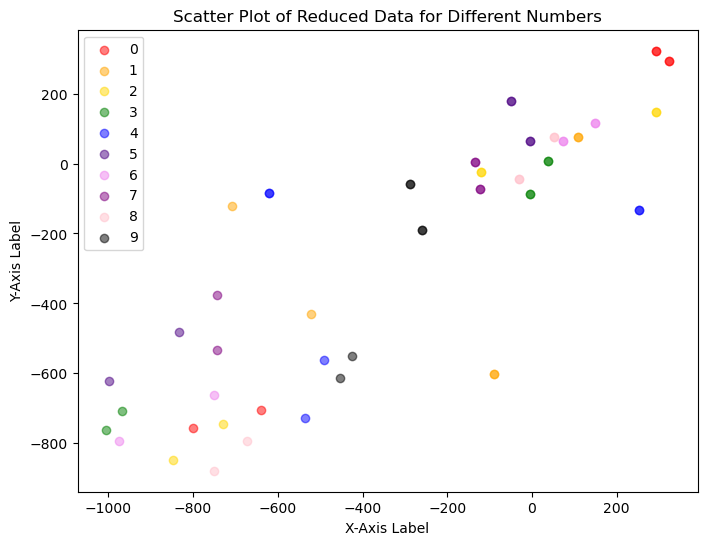

In [18]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig = plt.figure(figsize=(8, 6))

for i in range(10):
    points = np.column_stack((np.hstack(x_data[i]), np.hstack(y_data[i])))
    plt.scatter(x_data[i], y_data[i], c=colors[i], label=f'{i}', alpha=0.5)
    
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Scatter Plot of Reduced Data for Different Numbers')
plt.legend()
plt.show()

# # saving the data
# run = '2d_latent_space_convex_hull_VAE'
# plots_folder_name = 'latent_space_images_vae'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

In [ ]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig = plt.figure(figsize=(8, 6))

for i in range(10):  # Iterate through the two numbers
    points = np.column_stack((np.hstack(x_data[i]), np.hstack(y_data[i])))
#     hull = ConvexHull(points)
#     convex_hull_vertices = points[hull.vertices]
    plt.scatter(x_data[i], y_data[i], c=colors[i], s=5, alpha=1, marker='.', label=f'{i}')
#     plt.plot(convex_hull_vertices[:, 0], convex_hull_vertices[:, 1], 'r--', lw=2, label='Convex Hull', c=colors[i])
    
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Scatter Plot of Reduced Data for Different Numbers')
plt.legend()
plt.show()

# # saving the data
# run = 'convex_hull_and_scatter'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space_VAE/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

In [ ]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig, axes = plt.subplots(2, 5, figsize=(16, 6))

for i in range(10): 
    row = i // 5
    col = i % 5

    axes[row, col].scatter(x_data[i], y_data[i], c=colors[i], label=f'{i}')
    axes[row, col].set_xlabel('X-Axis Label')
    axes[row, col].set_ylabel('Y-Axis Label')
    axes[row, col].set_title(f'Scatter Plot of {i}')

plt.tight_layout()
plt.show()

# # saving the data
# run = '2d_latent_space_separate_scatters_VAE'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

In [ ]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig = plt.figure(figsize=(8, 6))

for i in range(10):  # Iterate through the two numbers
    points = np.column_stack((np.hstack(x_data[i]), np.hstack(y_data[i])))
    hull = ConvexHull(points)
    convex_hull_vertices = points[hull.vertices]
    plt.scatter(x_data[i], y_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')
    
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Scatter Plot of Reduced Data for Different Numbers')
plt.legend()
plt.show()